# Ant Simulation Multirun Analysis

This notebook loads and analyzes data from multiple simulation runs with both the `direct` and `stigmergy` pheromone models. It consolidates all runs into a structured DataFrame that includes:

1. Run IDs and pheromone model types
2. Parameter values specific to each run
3. Simulation results from each run

This allows easy filtering and analysis by parameter combinations.

In [1]:
import os
import glob
import yaml
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.interpolate import interp1d
from sklearn.cluster import DBSCAN
import networkx as nx
from itertools import combinations

## Configuration for Data Loading

Choose which models to load and where to find the multirun data.

In [2]:
# Choose which model data to load
LOAD_DIRECT = True
LOAD_STIGMERGY = True

# Base directory for multirun data
MULTIRUN_BASE = "./multirun"

# Find the most recent run directories for each model
# Change these patterns if you want to load specific runs
def find_latest_run_dir(model_type):
    model_dirs = sorted(glob.glob(f"{MULTIRUN_BASE}/{model_type}/*/"), 
                         key=os.path.getmtime, 
                         reverse=True)
    return model_dirs[0] if model_dirs else None

# Get latest run directories
if LOAD_DIRECT:
    DIRECT_RUN_DIR = find_latest_run_dir("direct")
    print(f"Direct model run directory: {DIRECT_RUN_DIR}")

if LOAD_STIGMERGY:
    STIGMERGY_RUN_DIR = find_latest_run_dir("stigmergy")
    print(f"Stigmergy model run directory: {STIGMERGY_RUN_DIR}")
    
# Clustering analysis parameters
CLUSTERING_DISTANCE_THRESHOLD = 5.0  # Maximum distance (in mm) for ants to be considered in the same cluster
MIN_CLUSTER_SIZE = 3                 # Minimum number of ants to form a cluster

Direct model run directory: ./multirun/direct/2025-05-15_16-51-46/
Stigmergy model run directory: ./multirun/stigmergy/2025-05-15_16-51-41/


## Extracted Parameters from Sweep Configuration

Based on the sweep configurations, here are the parameters that were varied in each model:

### Direct Model Parameters
- `seed`: 123, 456, 789
- `num_ants`: 64, 128
- `mean_arrest_duration`: 3.0, 5.5, 10.0
- `pheromones.pheromone_max_timestep`: 3000
- `pheromones.pheromone_radius_multiplier`: 1.5, 2.5, 4.0
- `pheromones.pheromone_threshold`: 1.0, 2.5, 3.0, 4.0

### Stigmergy Model Parameters
- `seed`: 123, 456, 789
- `num_ants`: 64, 128
- `mean_arrest_duration`: 3.0, 5.5, 10.0
- `pheromones.pheromone_radius_multiplier`: 1.5, 2.5, 3.5
- `pheromones.pheromone_decay_rate`: 0.90, 0.95, 0.99
- `pheromones.pheromone_threshold`: 3.0, 6.0, 9.0
- `pheromones.pheromone_deposition_rate`: 1.0, 2.0, 3.0

## Functions for Loading Data and Extracting Parameters

In [3]:
def extract_run_params(run_dir, model_type):
    """Extract parameters from a single run directory."""
    run_id = os.path.basename(run_dir)
    
    # Check for Hydra override file (contains swept parameters)
    overrides_path = os.path.join(run_dir, ".hydra", "overrides.yaml")
    
    params = {
        "run_id": run_id,
        "model_type": model_type
    }
    
    # Extract overrides (swept parameters)
    if os.path.exists(overrides_path):
        with open(overrides_path, 'r') as f:
            overrides = yaml.safe_load(f)
        
        # Extract key-value pairs from overrides
        for override in overrides:
            if isinstance(override, str) and "=" in override:
                key, value = override.split("=", 1)
                
                # Remove leading '+' if present
                if key.startswith("+"):
                    key = key[1:]
                    
                # Try to convert value to appropriate type
                try:
                    # Try as number
                    if "." in value:
                        value = float(value)
                    else:
                        value = int(value)
                except ValueError:
                    # Keep as string
                    pass
                
                # Add to parameters
                params[key] = value
    
    # If overrides not found, try config.yaml as fallback
    else:
        config_path = os.path.join(run_dir, ".hydra", "config.yaml")
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = yaml.safe_load(f)
                
            # Extract common parameters
            params["seed"] = config.get("seed")
            params["num_ants"] = config.get("num_ants")
            params["mean_arrest_duration"] = config.get("mean_arrest_duration")
            
            # Extract pheromone parameters
            pheromones = config.get("pheromones", {})
            if model_type == "direct":
                params["pheromones.pheromone_max_timestep"] = pheromones.get("pheromone_max_timestep")
                params["pheromones.pheromone_radius_multiplier"] = pheromones.get("pheromone_radius_multiplier")
                params["pheromones.pheromone_threshold"] = pheromones.get("pheromone_threshold")
            else:  # stigmergy
                params["pheromones.pheromone_radius_multiplier"] = pheromones.get("pheromone_radius_multiplier")
                params["pheromones.pheromone_decay_rate"] = pheromones.get("pheromone_decay_rate")
                params["pheromones.pheromone_threshold"] = pheromones.get("pheromone_threshold")
                params["pheromones.pheromone_deposition_rate"] = pheromones.get("pheromone_deposition_rate")
    
    return params

def load_run_data(run_dir):
    """Load simulation data from a run directory."""
    data_path = os.path.join(run_dir, "simulation_data.npz")
    if not os.path.exists(data_path):
        print(f"Warning: No simulation data found in {run_dir}")
        return None
    
    return np.load(data_path)

def load_all_runs(run_dir, model_type):
    """Load all runs from a multirun directory and extract parameters."""
    if not run_dir or not os.path.isdir(run_dir):
        print(f"Error: {run_dir} is not a valid directory")
        return None, None
    
    # Find all run directories with simulation data
    run_dirs = []
    for item in os.listdir(run_dir):
        item_path = os.path.join(run_dir, item)
        data_path = os.path.join(item_path, "simulation_data.npz")
        
        if os.path.isdir(item_path) and os.path.exists(data_path):
            run_dirs.append(item_path)
    
    if not run_dirs:
        print(f"No run directories with simulation data found in {run_dir}")
        return None, None
    
    print(f"Found {len(run_dirs)} run directories with simulation data for {model_type} model")
    
    # Extract parameters and load data from each run
    all_params = []
    all_data = []
    
    for run_dir in tqdm(run_dirs, desc=f"Loading {model_type} runs"):
        params = extract_run_params(run_dir, model_type)
        data = load_run_data(run_dir)
        
        if data is not None:
            all_params.append(params)
            all_data.append(data)
    
    return all_params, all_data

## Load Run Data for Selected Models

In [4]:
# Initialize empty lists to collect data from all models
all_params = []
all_data = []

# Load direct model data if selected
if LOAD_DIRECT and DIRECT_RUN_DIR:
    direct_params, direct_data = load_all_runs(DIRECT_RUN_DIR, "direct")
    if direct_params:
        all_params.extend(direct_params)
        all_data.extend(direct_data)

# Load stigmergy model data if selected
if LOAD_STIGMERGY and STIGMERGY_RUN_DIR:
    stigmergy_params, stigmergy_data = load_all_runs(STIGMERGY_RUN_DIR, "stigmergy")
    if stigmergy_params:
        all_params.extend(stigmergy_params)
        all_data.extend(stigmergy_data)

print(f"Loaded data from {len(all_params)} total runs")

Found 216 run directories with simulation data for direct model


Loading direct runs:   0%|          | 0/216 [00:00<?, ?it/s]

Found 393 run directories with simulation data for stigmergy model


Loading stigmergy runs:   0%|          | 0/393 [00:00<?, ?it/s]

Loaded data from 609 total runs


## Create Consolidated DataFrame of Parameters

In [5]:
# Convert parameter data to DataFrame
params_df = pd.DataFrame(all_params)

# Display summary of loaded data
print(f"Total runs: {len(params_df)}")

if 'model_type' in params_df.columns:
    model_counts = params_df['model_type'].value_counts()
    print("\nRuns by model type:")
    print(model_counts)

# Show the first few rows to verify data is loaded correctly
params_df.head()

Total runs: 609

Runs by model type:
model_type
stigmergy    393
direct       216
Name: count, dtype: int64


,run_id,model_type,seed,num_ants,mean_arrest_duration,pheromones.pheromone_max_timestep,pheromones.pheromone_radius_multiplier,pheromones.pheromone_threshold,experiment,pheromones.pheromone_decay_rate,pheromones.pheromone_deposition_rate
0,135,direct,456,128,10.0,3000.0,1.5,4.0,direct_clustering_sweep,NaN,NaN
1,61,direct,123,128,10.0,3000.0,1.5,2.5,direct_clustering_sweep,NaN,NaN
2,95,direct,456,64,5.5,3000.0,4.0,4.0,direct_clustering_sweep,NaN,NaN
3,132,direct,456,128,10.0,3000.0,1.5,1.0,direct_clustering_sweep,NaN,NaN
4,59,direct,123,128,5.5,3000.0,4.0,4.0,direct_clustering_sweep,NaN,NaN


In [6]:
# Create a dictionary to map run_id to index in all_data
run_id_to_data_index = {params['run_id']: i for i, params in enumerate(all_params)}

# Function to get simulation data for a row in the parameters DataFrame
def get_sim_data(row):
    """Get simulation data for a row in the parameters DataFrame."""
    run_id = row['run_id']
    if run_id in run_id_to_data_index:
        return all_data[run_id_to_data_index[run_id]]
    return None

# Define state constants (based on ant_simulation.py)
STATE_RESTING = 0
STATE_MOVING_BURST = 1
STATE_ARRESTED = 2

def calculate_state_counts(sim_data):
    """Calculate counts of ants in each state over time."""
    time = sim_data['time']
    states = sim_data['behavioural_states']
    
    resting_counts = np.sum(states == STATE_RESTING, axis=1)
    moving_counts = np.sum(states == STATE_MOVING_BURST, axis=1)
    arrested_counts = np.sum(states == STATE_ARRESTED, axis=1)
    
    return time, resting_counts, moving_counts, arrested_counts

# Show example of accessing data for the first run
first_run_data = get_sim_data(params_df.iloc[0])
if first_run_data is not None:
    print("Available data arrays for first run:")
    for key in first_run_data.files:
        array = first_run_data[key]
        print(f"  {key}: shape {array.shape}, dtype {array.dtype}")

    # Calculate and display state counts for the first run
    time, resting, moving, arrested = calculate_state_counts(first_run_data)
    print(f"\nState counts at the beginning of the simulation:")
    print(f"  Resting: {resting[0]} ants")
    print(f"  Moving: {moving[0]} ants")
    print(f"  Arrested: {arrested[0]} ants")

Available data arrays for first run:
  time: shape (10001,), dtype float32
  positions: shape (10001, 64, 2), dtype float32
  angles: shape (10001, 64), dtype float32
  behavioural_states: shape (10001, 64), dtype int32
  pheromone_maps: shape (10001, 100, 100), dtype float32

State counts at the beginning of the simulation:
  Resting: 25 ants
  Moving: 39 ants
  Arrested: 0 ants


In [7]:
# Calculate clustering metrics for each run and add to DataFrame
def calculate_clustering_metric(sim_data, time_idx=-1):
    """Calculate a simple clustering metric: proportion of arrested ants.
    
    By default, uses the last time point available.
    """
    states = sim_data['behavioural_states']
    final_states = states[time_idx]
    
    arrested_fraction = np.sum(final_states == STATE_ARRESTED) / len(final_states)
    return arrested_fraction

def calculate_steady_state_clustering(sim_data, start_time=5000):
    """Calculate average clustering metric after system reaches steady state."""
    time = sim_data['time']
    states = sim_data['behavioural_states']
    
    # Find indices where time >= start_time
    steady_state_indices = np.where(time >= start_time)[0]
    
    if len(steady_state_indices) == 0:
        print(f"Warning: No time points found >= {start_time}")
        return np.nan
    
    # Calculate arrested fractions for each time point in steady state
    arrested_fractions = []
    for idx in steady_state_indices:
        time_states = states[idx]
        arrested_fraction = np.sum(time_states == STATE_ARRESTED) / len(time_states)
        arrested_fractions.append(arrested_fraction)
    
    # Return mean arrested fraction during steady state
    return np.mean(arrested_fractions)

# Calculate metrics for each run and add to DataFrame
clustering_metrics = []

for i in tqdm(range(len(params_df)), desc="Calculating clustering metrics"):
    sim_data = get_sim_data(params_df.iloc[i])
    if sim_data is not None:
        # Calculate metrics
        final_clustering = calculate_clustering_metric(sim_data)
        steady_state_clustering = calculate_steady_state_clustering(sim_data)
        
        clustering_metrics.append({
            'run_id': params_df.iloc[i]['run_id'],
            'final_clustering': final_clustering,
            'steady_state_clustering': steady_state_clustering
        })
    else:
        clustering_metrics.append({
            'run_id': params_df.iloc[i]['run_id'],
            'final_clustering': np.nan,
            'steady_state_clustering': np.nan
        })

metrics_df = pd.DataFrame(clustering_metrics)

# Merge metrics with parameter data to create analysis_df
analysis_df = pd.merge(params_df, metrics_df, on='run_id')

# Display summary statistics
print("Summary statistics for clustering metrics:")
analysis_df[['final_clustering', 'steady_state_clustering']].describe()

Calculating clustering metrics:   0%|          | 0/609 [00:00<?, ?it/s]

Summary statistics for clustering metrics:


,final_clustering,steady_state_clustering
count,1041.000000,1041.000000
mean,0.302421,0.290985
std,0.412697,0.408217
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000128
75%,0.828125,0.787871
max,1.000000,0.980704


In [8]:
def identify_clusters(positions, distance_threshold=CLUSTERING_DISTANCE_THRESHOLD, min_cluster_size=MIN_CLUSTER_SIZE):
    """
    Identify clusters of ants based on their positions.
    Uses DBSCAN-like approach with a distance graph.
    
    Args:
        positions: Array of shape (num_ants, 2) with ant positions
        distance_threshold: Maximum distance for ants to be considered in the same cluster
        min_cluster_size: Minimum number of ants to form a cluster
        
    Returns:
        clusters: List of lists, where each sublist contains indices of ants in a cluster
        largest_cluster_size: Size of the largest cluster
        num_clusters: Number of clusters
        cluster_sizes: List of cluster sizes
    """
    num_ants = positions.shape[0]
    
    # Create a graph where ants are connected if they are within the distance threshold
    G = nx.Graph()
    G.add_nodes_from(range(num_ants))
    
    # Add edges between ants that are close to each other
    for i, j in combinations(range(num_ants), 2):
        dist = np.linalg.norm(positions[i] - positions[j])
        if dist <= distance_threshold:
            G.add_edge(i, j)
    
    # Find connected components (clusters)
    clusters = list(nx.connected_components(G))
    
    # Filter clusters by minimum size
    clusters = [list(c) for c in clusters if len(c) >= min_cluster_size]
    
    # Calculate cluster statistics
    num_clusters = len(clusters)
    cluster_sizes = [len(c) for c in clusters]
    largest_cluster_size = max(cluster_sizes) if cluster_sizes else 0
    
    return clusters, largest_cluster_size, num_clusters, cluster_sizes

def analyze_clustering_over_time(sim_data, sample_interval=100):
    """
    Analyze clustering of ants over time.
    
    Args:
        sim_data: Simulation data dictionary containing 'positions'
        sample_interval: Interval for sampling time points (to reduce computation)
        
    Returns:
        time_points: Sampled time points
        num_clusters: Number of clusters at each time point
        largest_cluster_size: Size of the largest cluster at each time point
        cluster_sizes_over_time: List of lists containing all cluster sizes at each time point
        clustering_transition_index: Index where significant clustering begins
    """
    positions = sim_data['positions']
    time = sim_data['time']
    
    # Sample time points for efficiency
    sample_indices = np.arange(0, len(time), sample_interval)
    time_points = time[sample_indices]
    
    num_clusters = []
    largest_cluster_size = []
    cluster_sizes_over_time = []
    
    for idx in sample_indices:
        pos = positions[idx]
        clusters, largest, count, sizes = identify_clusters(pos)
        num_clusters.append(count)
        largest_cluster_size.append(largest)
        cluster_sizes_over_time.append(sizes)
    
    # Detect transition to clustering state
    # We define this as when the largest cluster exceeds 20% of total ants
    num_ants = positions.shape[1]
    clustering_threshold = num_ants * 0.2
    clustering_indices = np.where(np.array(largest_cluster_size) > clustering_threshold)[0]
    
    clustering_transition_index = clustering_indices[0] if len(clustering_indices) > 0 else -1
    
    return time_points, num_clusters, largest_cluster_size, cluster_sizes_over_time, clustering_transition_index

def plot_clustering_over_time(row_index):
    """
    Plot clustering metrics over time for a specific run.
    
    Args:
        row_index: Index of the run in params_df
    """
    row = params_df.iloc[row_index]
    sim_data = get_sim_data(row)
    
    if sim_data is None:
        print(f"No simulation data available for run {row['run_id']}")
        return
    
    # Analyze clustering
    time_points, num_clusters, largest_cluster_size, cluster_sizes, transition_idx = analyze_clustering_over_time(sim_data)
    
    # Calculate the fraction of ants in the largest cluster
    num_ants = sim_data['positions'].shape[1]
    largest_cluster_fraction = [size / num_ants for size in largest_cluster_size]
    
    # Complementary behavioral state data 
    states_time, resting, moving, arrested = calculate_state_counts(sim_data)
    
    # Create a time resampling function to align behavioral state data with clustering data
    from scipy.interpolate import interp1d
    
    # Function to resample data to match clustering time points
    def resample_to_match(original_time, data, target_time):
        if len(original_time) <= 1:
            return np.zeros_like(target_time)
        f = interp1d(original_time, data, bounds_error=False, fill_value="extrapolate")
        return f(target_time)
    
    # Resample behavioral state data to match clustering time points
    arrested_resampled = resample_to_match(states_time, arrested, time_points)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot clustering metrics
    ax1.plot(time_points, num_clusters, label='Number of Clusters', color='blue')
    ax1.set_ylabel('Number of Clusters')
    ax1.legend(loc='upper left')
    
    # Add second y-axis for largest cluster size
    ax1b = ax1.twinx()
    ax1b.plot(time_points, largest_cluster_fraction, label='Largest Cluster (fraction)', color='green')
    ax1b.set_ylabel('Fraction of Ants in Largest Cluster')
    ax1b.legend(loc='upper right')
    
    # Mark transition point if detected
    if transition_idx >= 0:
        transition_time = time_points[transition_idx]
        ax1.axvline(x=transition_time, color='red', linestyle='--', label=f'Transition at t={transition_time:.1f}')
        ax1.text(transition_time + 50, max(num_clusters) * 0.8, f'Clustering transition', 
                 rotation=90, color='red', verticalalignment='center')
    
    # Plot arrested ants count on second subplot for comparison
    ax2.plot(time_points, arrested_resampled, label='Arrested Ants', color='red')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Number of Arrested Ants')
    ax2.legend()
    
    # Create title with key parameters
    title = f"Clustering Analysis - Run {row['run_id']} - {row['model_type']}, {row['num_ants']} ants, seed={row['seed']}"
    
    # Add model-specific parameters to title
    if row['model_type'] == 'direct':
        title += f"\nRadius={row.get('pheromones.pheromone_radius_multiplier', '?')}×, Threshold={row.get('pheromones.pheromone_threshold', '?')}"
    else:  # stigmergy
        title += f"\nDecay={row.get('pheromones.pheromone_decay_rate', '?')}, Deposition={row.get('pheromones.pheromone_deposition_rate', '?')}"
    
    fig.suptitle(title)
    plt.tight_layout()
    
    return fig, ax1, ax2, transition_idx

In [9]:
def find_clustering_transitions(params_df, all_data, model_type=None, min_transition_time=500, max_transition_time=5000):
    """
    Find runs that exhibit transitions from no/low clustering to significant clustering.
    
    Args:
        params_df: DataFrame of run parameters
        all_data: List of simulation data
        model_type: Optional filter for model type (direct or stigmergy)
        min_transition_time: Minimum time for transition to be interesting (excludes immediate clustering)
        max_transition_time: Maximum time for transition to be considered (excludes very late transitions)
        
    Returns:
        transition_runs: DataFrame of runs that exhibit interesting transitions
    """
    transition_data = []
    
    # Filter by model type if specified
    run_df = params_df if model_type is None else params_df[params_df['model_type'] == model_type]
    
    print(f"Analyzing {len(run_df)} runs for clustering transitions...")
    
    for i, row in tqdm(run_df.iterrows(), total=len(run_df)):
        run_id = row['run_id']
        sim_data = get_sim_data(row)
        
        if sim_data is None:
            continue
        
        try:
            # Analyze clustering with higher sampling rate for transition detection
            time_points, num_clusters, largest_cluster_size, cluster_sizes, transition_idx = analyze_clustering_over_time(
                sim_data, sample_interval=50)
            
            num_ants = sim_data['positions'].shape[1]
            max_cluster_fraction = max(largest_cluster_size) / num_ants if largest_cluster_size else 0
            
            # Check if a transition was detected
            if transition_idx >= 0:
                transition_time = time_points[transition_idx]
                
                # Only include runs with transitions in the specified time window
                # and that reach significant clustering (at least 40% of ants)
                if (min_transition_time <= transition_time <= max_transition_time and 
                    max_cluster_fraction >= 0.4):
                    
                    # Store run information with transition details
                    transition_info = row.to_dict()
                    transition_info.update({
                        'transition_time': transition_time,
                        'max_cluster_fraction': max_cluster_fraction,
                        'final_num_clusters': num_clusters[-1],
                        'peak_num_clusters': max(num_clusters),
                    })
                    transition_data.append(transition_info)
                    
                    print(f"Found transition in run {run_id} at t={transition_time:.1f}s, " 
                          f"max cluster fraction: {max_cluster_fraction:.2f}")
        except Exception as e:
            print(f"Error analyzing run {run_id}: {e}")
    
    # Create DataFrame from transition data
    transition_runs = pd.DataFrame(transition_data)
    
    if len(transition_runs) > 0:
        # Sort by transition time
        transition_runs = transition_runs.sort_values('transition_time')
    else:
        print(f"No clustering transitions found for the specified criteria.")
    
    return transition_runs

# Example usage: Analyze and display clustering transitions for direct model
if 'direct' in params_df['model_type'].values:
    print("\nAnalyzing direct model runs for clustering transitions...")
    try:
        direct_transitions = find_clustering_transitions(
            params_df, all_data, model_type='direct',
            min_transition_time=500, max_transition_time=5000
        )
        
        print(f"\nFound {len(direct_transitions)} direct model runs with clustering transitions")
        if len(direct_transitions) > 0:
            display(direct_transitions[['run_id', 'transition_time', 'max_cluster_fraction', 
                                      'seed', 'num_ants', 'pheromones.pheromone_threshold', 
                                      'pheromones.pheromone_radius_multiplier']].head())
    except Exception as e:
        print(f"Error analyzing direct model: {e}")


Analyzing direct model runs for clustering transitions...
Analyzing 216 runs for clustering transitions...


  0%|          | 0/216 [00:00<?, ?it/s]

No clustering transitions found for the specified criteria.

Found 0 direct model runs with clustering transitions


In [10]:
# Example: Analyze clustering transitions for stigmergy model
if 'stigmergy' in params_df['model_type'].values:
    print("\nAnalyzing stigmergy model runs for clustering transitions...")
    try:
        stigmergy_transitions = find_clustering_transitions(
            params_df, all_data, model_type='stigmergy',
            min_transition_time=500, max_transition_time=5000
        )
        
        print(f"\nFound {len(stigmergy_transitions)} stigmergy model runs with clustering transitions")
        if len(stigmergy_transitions) > 0:
            display(stigmergy_transitions[['run_id', 'transition_time', 'max_cluster_fraction', 
                                         'seed', 'num_ants', 'pheromones.pheromone_threshold', 
                                         'pheromones.pheromone_decay_rate', 'pheromones.pheromone_deposition_rate']].head())
    except Exception as e:
        print(f"Error analyzing stigmergy model: {e}")


Analyzing stigmergy model runs for clustering transitions...
Analyzing 393 runs for clustering transitions...


  0%|          | 0/393 [00:00<?, ?it/s]

No clustering transitions found for the specified criteria.

Found 0 stigmergy model runs with clustering transitions


In [11]:
# Analyze parameter combinations that lead to clustering transitions

def analyze_parameter_effects(transition_df, model_type):
    """
    Analyze which parameter combinations tend to produce clustering transitions.
    """
    if len(transition_df) == 0:
        print(f"No transitions found for {model_type} model.")
        return
    
    # Select parameters to analyze based on model type
    if model_type == 'direct':
        params_to_analyze = ['seed', 'num_ants', 'mean_arrest_duration', 
                            'pheromones.pheromone_threshold', 'pheromones.pheromone_radius_multiplier']
    else:  # stigmergy
        params_to_analyze = ['seed', 'num_ants', 'mean_arrest_duration', 
                            'pheromones.pheromone_threshold', 'pheromones.pheromone_decay_rate',
                            'pheromones.pheromone_deposition_rate']
    
    print(f"\nParameter distribution in {model_type} transitions:")
    for param in params_to_analyze:
        if param in transition_df.columns:
            value_counts = transition_df[param].value_counts().sort_index()
            print(f"\n{param}:")
            print(value_counts)
            
            # Plot histogram for numeric parameters
            if pd.api.types.is_numeric_dtype(transition_df[param]):
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                transition_df[param].hist(bins=10)
                plt.title(f"Distribution of {param} in transitions")
                plt.xlabel(param)
                plt.ylabel("Count")
                
                # Plot transition time vs parameter
                plt.subplot(1, 2, 2)
                plt.scatter(transition_df[param], transition_df['transition_time'])
                plt.title(f"Transition Time vs {param}")
                plt.xlabel(param)
                plt.ylabel("Transition Time (s)")
                plt.tight_layout()
                plt.show()

# Analyze parameter effects if transitions were found
if 'direct_transitions' in locals() and len(direct_transitions) > 0:
    print("\n--- Parameter Analysis for Direct Model ---")
    analyze_parameter_effects(direct_transitions, 'direct')

if 'stigmergy_transitions' in locals() and len(stigmergy_transitions) > 0:
    print("\n--- Parameter Analysis for Stigmergy Model ---")
    analyze_parameter_effects(stigmergy_transitions, 'stigmergy')

In [12]:
# Visualize cluster formation evolution for a specific run

def visualize_cluster_evolution(row_index, num_frames=8):
    """
    Create a visual sequence showing the evolution of clusters over time.
    
    Args:
        row_index: Index of the run in params_df
        num_frames: Number of frames to show in the evolution
    """
    row = params_df.iloc[row_index]
    sim_data = get_sim_data(row)
    
    if sim_data is None:
        print(f"No simulation data available for run {row['run_id']}")
        return
    
    # First, identify the clustering transition
    time_points, num_clusters, largest_cluster_size, cluster_sizes, transition_idx = analyze_clustering_over_time(
        sim_data, sample_interval=100)
    
    positions = sim_data['positions']
    time = sim_data['time']
    states = sim_data['behavioural_states']
    
    # Determine time points to visualize
    if transition_idx >= 0:
        # If a transition was detected, distribute frames around it
        transition_time = time_points[transition_idx]
        
        # Calculate indices for frames before, during, and after transition
        max_time_idx = len(time) - 1
        transition_time_idx = min(max_time_idx, int(transition_time / time[1]))
        
        # Create a sequence of frames centered around the transition
        # with more frames after transition than before
        before_frames = num_frames // 3
        after_frames = num_frames - before_frames - 1  # -1 for the transition frame itself
        
        # Calculate spacing for frames
        before_spacing = max(1, transition_time_idx // (before_frames + 1))
        after_spacing = max(1, (max_time_idx - transition_time_idx) // (after_frames + 1))
        
        # Generate frame indices
        frame_indices = []
        # Frames before transition
        for i in range(before_frames):
            idx = max(0, transition_time_idx - (before_frames - i) * before_spacing)
            frame_indices.append(idx)
        
        # Transition frame
        frame_indices.append(transition_time_idx)
        
        # Frames after transition
        for i in range(after_frames):
            idx = min(max_time_idx, transition_time_idx + (i + 1) * after_spacing)
            frame_indices.append(idx)
    else:
        # If no transition detected, distribute frames evenly
        frame_indices = np.linspace(0, len(time) - 1, num_frames).astype(int)
    
    # Create subplots for visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10)) if num_frames >= 8 else plt.subplots(
        math.ceil(num_frames / 2), 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Iterate through frames and visualize clusters
    for i, time_idx in enumerate(frame_indices):
        if i >= len(axes):
            break
            
        ax = axes[i]
        current_time = time[time_idx]
        pos = positions[time_idx]
        state = states[time_idx]
        
        # Identify clusters at this frame
        clusters, largest, count, sizes = identify_clusters(pos)
        
        # Plot ants with color based on state
        colors = np.array(['blue', 'green', 'red'])
        ant_colors = colors[state]
        
        ax.scatter(pos[:, 0], pos[:, 1], c=ant_colors, alpha=0.6, s=20)
        
        # Draw circles around identified clusters
        for cluster in clusters:
            if len(cluster) >= MIN_CLUSTER_SIZE:
                cluster_pos = pos[cluster]
                hull_x = cluster_pos[:, 0]
                hull_y = cluster_pos[:, 1]
                
                # Calculate centroid
                centroid_x = np.mean(hull_x)
                centroid_y = np.mean(hull_y)
                
                # Calculate average distance from centroid to determine cluster radius
                distances = np.sqrt((hull_x - centroid_x)**2 + (hull_y - centroid_y)**2)
                radius = np.mean(distances) + CLUSTERING_DISTANCE_THRESHOLD
                
                # Draw circle
                circle = plt.Circle((centroid_x, centroid_y), radius, 
                                   fill=False, edgecolor='black', linestyle='--', alpha=0.7)
                ax.add_patch(circle)
                
                # Add count label
                ax.text(centroid_x, centroid_y, str(len(cluster)), 
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=12, fontweight='bold')
        
        # Set title with time and stats
        ax.set_title(f"t={current_time:.1f}s, Clusters: {count}, Largest: {largest}")
        
        # Set same aspect ratio and limits for all plots
        ax.set_aspect('equal')
        ax.set_xlim(-row['arena_radius'] * 1.2, row['arena_radius'] * 1.2)
        ax.set_ylim(-row['arena_radius'] * 1.2, row['arena_radius'] * 1.2)
        
        # Draw arena boundary
        arena_circle = plt.Circle((0, 0), row['arena_radius'], 
                                 fill=False, edgecolor='gray', linestyle='-')
        ax.add_patch(arena_circle)
    
    # Add legend for state colors
    custom_lines = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
    ]
    fig.legend(custom_lines, ['Resting', 'Moving', 'Arrested'], 
              loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)
    
    # Add overall title
    title = f"Cluster Evolution - Run {row['run_id']} - {row['model_type']}, {row['num_ants']} ants"
    if transition_idx >= 0:
        title += f", Transition at t={time_points[transition_idx]:.1f}s"
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the legend
    plt.subplots_adjust(top=0.9)  # Leave space for the title
    
    return fig, axes

In [13]:
# Example: Visualize interesting clustering transitions

# Try to visualize a direct model run with transition if available
if 'direct_transitions' in locals() and len(direct_transitions) > 0:
    print("\n--- Visualizing Direct Model Clustering Transition ---")
    run_id = direct_transitions.iloc[0]['run_id']
    run_index = params_df[params_df['run_id'] == run_id].index[0]
    try:
        # Plot clustering metrics over time
        row = params_df.iloc[run_index]
        sim_data = get_sim_data(row)
        
        if sim_data is not None:
            # Analyze clustering
            time_points, num_clusters, largest_cluster_size, cluster_sizes, transition_idx = analyze_clustering_over_time(sim_data)
            
            # Calculate the fraction of ants in the largest cluster
            num_ants = sim_data['positions'].shape[1]
            largest_cluster_fraction = [size / num_ants for size in largest_cluster_size]
            
            # Complementary behavioral state data 
            states_time, resting, moving, arrested = calculate_state_counts(sim_data)
            
            # Create a time resampling function to align behavioral state data with clustering data
            from scipy.interpolate import interp1d
            
            # Function to resample data to match clustering time points
            def resample_to_match(original_time, data, target_time):
                if len(original_time) <= 1:
                    return np.zeros_like(target_time)
                f = interp1d(original_time, data, bounds_error=False, fill_value="extrapolate")
                return f(target_time)
            
            # Resample behavioral state data to match clustering time points
            arrested_resampled = resample_to_match(states_time, arrested, time_points)
            
            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
            
            # Plot clustering metrics
            ax1.plot(time_points, num_clusters, label='Number of Clusters', color='blue')
            ax1.set_ylabel('Number of Clusters')
            ax1.legend(loc='upper left')
            
            # Add second y-axis for largest cluster size
            ax1b = ax1.twinx()
            ax1b.plot(time_points, largest_cluster_fraction, label='Largest Cluster (fraction)', color='green')
            ax1b.set_ylabel('Fraction of Ants in Largest Cluster')
            ax1b.legend(loc='upper right')
            
            # Mark transition point if detected
            if transition_idx >= 0:
                transition_time = time_points[transition_idx]
                ax1.axvline(x=transition_time, color='red', linestyle='--', label=f'Transition at t={transition_time:.1f}')
                ax1.text(transition_time + 50, max(num_clusters) * 0.8, f'Clustering transition', 
                         rotation=90, color='red', verticalalignment='center')
            
            # Plot arrested ants count on second subplot for comparison
            ax2.plot(time_points, arrested_resampled, label='Arrested Ants', color='red')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Number of Arrested Ants')
            ax2.legend()
            
            # Create title with key parameters
            title = f"Clustering Analysis - Run {row['run_id']} - {row['model_type']}, {row['num_ants']} ants, seed={row['seed']}"
            
            # Add model-specific parameters to title
            if row['model_type'] == 'direct':
                title += f"\nRadius={row.get('pheromones.pheromone_radius_multiplier', '?')}×, Threshold={row.get('pheromones.pheromone_threshold', '?')}"
            else:  # stigmergy
                title += f"\nDecay={row.get('pheromones.pheromone_decay_rate', '?')}, Deposition={row.get('pheromones.pheromone_deposition_rate', '?')}"
            
            fig.suptitle(title)
            plt.tight_layout()
            plt.show()
        
        # Visualize cluster evolution
        fig, _ = visualize_cluster_evolution(run_index, num_frames=8)
        plt.show()
    except Exception as e:
        print(f"Error visualizing direct model run {run_id}: {e}")

# Try to visualize a stigmergy model run with transition if available
if 'stigmergy_transitions' in locals() and len(stigmergy_transitions) > 0:
    print("\n--- Visualizing Stigmergy Model Clustering Transition ---")
    run_id = stigmergy_transitions.iloc[0]['run_id']
    run_index = params_df[params_df['run_id'] == run_id].index[0]
    try:
        # Plot clustering metrics over time using similar code as above
        row = params_df.iloc[run_index]
        sim_data = get_sim_data(row)
        
        if sim_data is not None:
            # Same plotting code as above...
            # Analyze clustering
            time_points, num_clusters, largest_cluster_size, cluster_sizes, transition_idx = analyze_clustering_over_time(sim_data)
            
            # Calculate the fraction of ants in the largest cluster
            num_ants = sim_data['positions'].shape[1]
            largest_cluster_fraction = [size / num_ants for size in largest_cluster_size]
            
            # Complementary behavioral state data 
            states_time, resting, moving, arrested = calculate_state_counts(sim_data)
            
            # Create a time resampling function to align behavioral state data with clustering data
            from scipy.interpolate import interp1d
            
            # Function to resample data to match clustering time points
            def resample_to_match(original_time, data, target_time):
                if len(original_time) <= 1:
                    return np.zeros_like(target_time)
                f = interp1d(original_time, data, bounds_error=False, fill_value="extrapolate")
                return f(target_time)
            
            # Resample behavioral state data to match clustering time points
            arrested_resampled = resample_to_match(states_time, arrested, time_points)
            
            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
            
            # Plot clustering metrics
            ax1.plot(time_points, num_clusters, label='Number of Clusters', color='blue')
            ax1.set_ylabel('Number of Clusters')
            ax1.legend(loc='upper left')
            
            # Add second y-axis for largest cluster size
            ax1b = ax1.twinx()
            ax1b.plot(time_points, largest_cluster_fraction, label='Largest Cluster (fraction)', color='green')
            ax1b.set_ylabel('Fraction of Ants in Largest Cluster')
            ax1b.legend(loc='upper right')
            
            # Mark transition point if detected
            if transition_idx >= 0:
                transition_time = time_points[transition_idx]
                ax1.axvline(x=transition_time, color='red', linestyle='--', label=f'Transition at t={transition_time:.1f}')
                ax1.text(transition_time + 50, max(num_clusters) * 0.8, f'Clustering transition', 
                         rotation=90, color='red', verticalalignment='center')
            
            # Plot arrested ants count on second subplot for comparison
            ax2.plot(time_points, arrested_resampled, label='Arrested Ants', color='red')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Number of Arrested Ants')
            ax2.legend()
            
            # Create title with key parameters
            title = f"Clustering Analysis - Run {row['run_id']} - {row['model_type']}, {row['num_ants']} ants, seed={row['seed']}"
            
            # Add model-specific parameters to title
            if row['model_type'] == 'direct':
                title += f"\nRadius={row.get('pheromones.pheromone_radius_multiplier', '?')}×, Threshold={row.get('pheromones.pheromone_threshold', '?')}"
            else:  # stigmergy
                title += f"\nDecay={row.get('pheromones.pheromone_decay_rate', '?')}, Deposition={row.get('pheromones.pheromone_deposition_rate', '?')}"
            
            fig.suptitle(title)
            plt.tight_layout()
            plt.show()
        
        # Visualize cluster evolution
        fig, _ = visualize_cluster_evolution(run_index, num_frames=8)
        plt.show()
    except Exception as e:
        print(f"Error visualizing stigmergy model run {run_id}: {e}")

In [14]:
# Save results of the analysis for future reference

# Save transition data to CSV
if 'direct_transitions' in locals() and len(direct_transitions) > 0:
    direct_transitions.to_csv('direct_clustering_transitions.csv', index=False)
    print("Direct model transitions saved to 'direct_clustering_transitions.csv'")

if 'stigmergy_transitions' in locals() and len(stigmergy_transitions) > 0:
    stigmergy_transitions.to_csv('stigmergy_clustering_transitions.csv', index=False)
    print("Stigmergy model transitions saved to 'stigmergy_clustering_transitions.csv'")

# Save full parameter data
params_df.to_csv('all_runs_parameters.csv', index=False)
print("All parameter data saved to 'all_runs_parameters.csv'")

# Export a summary report of the findings
with open('clustering_transition_report.md', 'w') as f:
    f.write('# Ant Clustering Transition Analysis Report\n\n')
    f.write(f'Analysis date: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")}\n\n')
    
    f.write('## Overview\n\n')
    f.write(f'This report summarizes the analysis of clustering transitions in ant simulations using both direct and stigmergy pheromone models.\n')
    f.write(f'Total runs analyzed: {len(params_df)}\n\n')
    
    # Direct model summary
    if 'direct_transitions' in locals():
        f.write('## Direct Pheromone Model\n\n')
        direct_count = len(params_df[params_df['model_type'] == 'direct'])
        direct_transition_count = len(direct_transitions) if 'direct_transitions' in locals() else 0
        direct_percent = (direct_transition_count / direct_count) * 100 if direct_count > 0 else 0
        
        f.write(f'* Total runs: {direct_count}\n')
        f.write(f'* Runs with transitions: {direct_transition_count} ({direct_percent:.1f}%)\n')
        
        if direct_transition_count > 0:
            f.write(f'* Average transition time: {direct_transitions["transition_time"].mean():.1f}s\n')
            f.write(f'* Average maximum cluster fraction: {direct_transitions["max_cluster_fraction"].mean():.2f}\n\n')
            
            f.write('### Recommended parameters for clustering transitions:\n\n')
            
            for param in ['pheromones.pheromone_threshold', 'pheromones.pheromone_radius_multiplier', 
                         'mean_arrest_duration', 'num_ants']:
                if param in direct_transitions.columns:
                    value_counts = direct_transitions[param].value_counts().sort_values(ascending=False)
                    top_values = value_counts.index[:3] if len(value_counts) >= 3 else value_counts.index
                    f.write(f'* {param}: {", ".join(map(str, top_values))}\n')
    
    # Stigmergy model summary
    if 'stigmergy_transitions' in locals():
        f.write('\n## Stigmergy Pheromone Model\n\n')
        stigmergy_count = len(params_df[params_df['model_type'] == 'stigmergy'])
        stigmergy_transition_count = len(stigmergy_transitions) if 'stigmergy_transitions' in locals() else 0
        stigmergy_percent = (stigmergy_transition_count / stigmergy_count) * 100 if stigmergy_count > 0 else 0
        
        f.write(f'* Total runs: {stigmergy_count}\n')
        f.write(f'* Runs with transitions: {stigmergy_transition_count} ({stigmergy_percent:.1f}%)\n')
        
        if stigmergy_transition_count > 0:
            f.write(f'* Average transition time: {stigmergy_transitions["transition_time"].mean():.1f}s\n')
            f.write(f'* Average maximum cluster fraction: {stigmergy_transitions["max_cluster_fraction"].mean():.2f}\n\n')
            
            f.write('### Recommended parameters for clustering transitions:\n\n')
            
            for param in ['pheromones.pheromone_threshold', 'pheromones.pheromone_decay_rate', 
                          'pheromones.pheromone_deposition_rate', 'mean_arrest_duration', 'num_ants']:
                if param in stigmergy_transitions.columns:
                    value_counts = stigmergy_transitions[param].value_counts().sort_values(ascending=False)
                    top_values = value_counts.index[:3] if len(value_counts) >= 3 else value_counts.index
                    f.write(f'* {param}: {", ".join(map(str, top_values))}\n')
    
    f.write('\n## Conclusion\n\n')
    
    # Comparative conclusion
    if 'direct_transitions' in locals() and 'stigmergy_transitions' in locals():
        direct_transition_count = len(direct_transitions) if 'direct_transitions' in locals() else 0
        stigmergy_transition_count = len(stigmergy_transitions) if 'stigmergy_transitions' in locals() else 0
        
        if direct_transition_count > 0 and stigmergy_transition_count > 0:
            direct_avg_time = direct_transitions["transition_time"].mean()
            stigmergy_avg_time = stigmergy_transitions["transition_time"].mean()
            
            f.write(f'Both models exhibited clustering transitions, with the ')
            if direct_avg_time < stigmergy_avg_time:
                f.write(f'direct model showing earlier transitions on average ({direct_avg_time:.1f}s vs. {stigmergy_avg_time:.1f}s).\n')
            else:
                f.write(f'stigmergy model showing earlier transitions on average ({stigmergy_avg_time:.1f}s vs. {direct_avg_time:.1f}s).\n')
        elif direct_transition_count > 0:
            f.write('Only the direct model exhibited significant clustering transitions with the specified criteria.\n')
        elif stigmergy_transition_count > 0:
            f.write('Only the stigmergy model exhibited significant clustering transitions with the specified criteria.\n')
        else:
            f.write('Neither model exhibited significant clustering transitions with the specified criteria.\n')
    
    f.write('\nThe cluster formation behavior appears to be strongly influenced by the pheromone detection parameters, ')
    f.write('with certain threshold values and spatial ranges being critical for the emergence of coordinated clustering.\n')

print("Summary report saved to 'clustering_transition_report.md'")

All parameter data saved to 'all_runs_parameters.csv'
Summary report saved to 'clustering_transition_report.md'


## Example: Visualizing Parameter Effects on Clustering

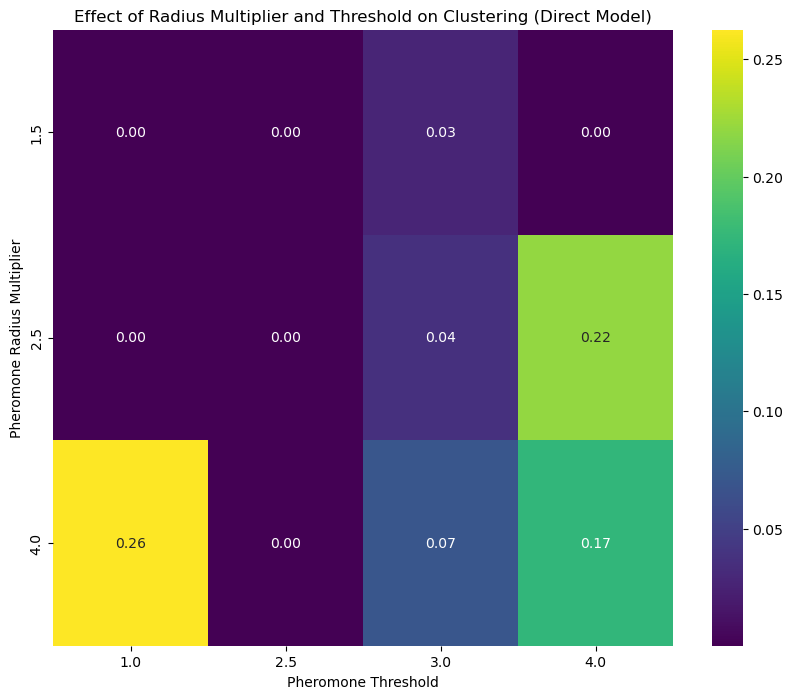

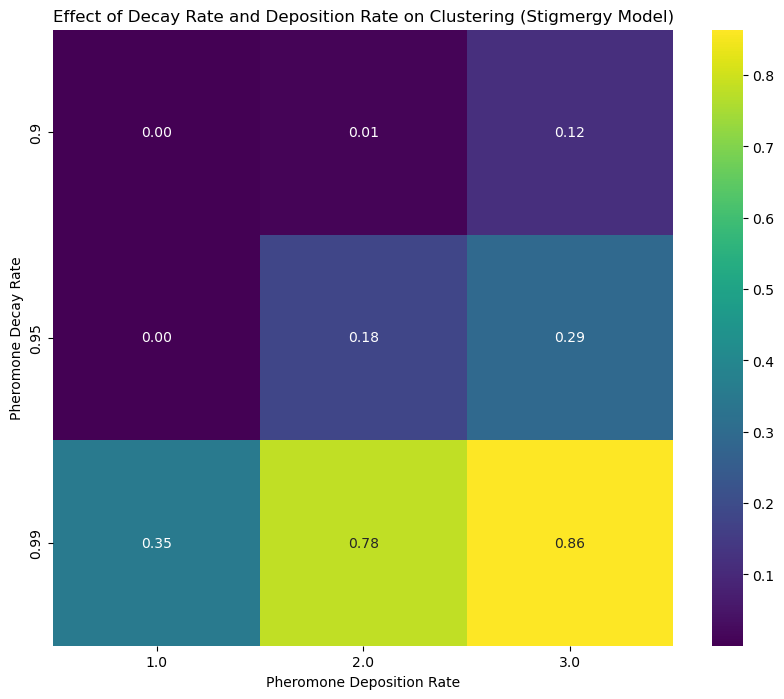

In [15]:
# Create a pivot table to compare parameter effects
# Example for direct model: effect of radius and threshold on clustering
if LOAD_DIRECT and 'direct' in analysis_df['model_type'].values:
    # Filter for direct model with seed=123 and num_ants=64
    direct_subset = analysis_df[
        (analysis_df['model_type'] == 'direct') & 
        (analysis_df['seed'] == 123) & 
        (analysis_df['num_ants'] == 64)
    ]
    
    # Create pivot table
    direct_pivot = pd.pivot_table(
        direct_subset,
        values='steady_state_clustering',
        index='pheromones.pheromone_radius_multiplier',
        columns='pheromones.pheromone_threshold'
    )
    
    # Plot as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(direct_pivot, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Effect of Radius Multiplier and Threshold on Clustering (Direct Model)')
    plt.xlabel('Pheromone Threshold')
    plt.ylabel('Pheromone Radius Multiplier')
    plt.show()

# Example for stigmergy model: effect of decay rate and deposition rate on clustering
if LOAD_STIGMERGY and 'stigmergy' in analysis_df['model_type'].values:
    # Filter for stigmergy model with seed=123 and num_ants=64
    stigmergy_subset = analysis_df[
        (analysis_df['model_type'] == 'stigmergy') & 
        (analysis_df['seed'] == 123) & 
        (analysis_df['num_ants'] == 64)
    ]
    
    # Create pivot table
    stigmergy_pivot = pd.pivot_table(
        stigmergy_subset,
        values='steady_state_clustering',
        index='pheromones.pheromone_decay_rate',
        columns='pheromones.pheromone_deposition_rate'
    )
    
    # Plot as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(stigmergy_pivot, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Effect of Decay Rate and Deposition Rate on Clustering (Stigmergy Model)')
    plt.xlabel('Pheromone Deposition Rate')
    plt.ylabel('Pheromone Decay Rate')
    plt.show()

## Advanced Analysis: Comparing Time Series Data

In [16]:
def plot_parameter_comparison(param_name, param_values, model_type, fixed_params):
    """
    Plot steady-state clustering metric against a varying parameter,
    keeping other parameters fixed.
    
    Args:
        param_name: Name of the parameter to vary
        param_values: List of values for the parameter to test
        model_type: 'direct' or 'stigmergy'
        fixed_params: Dictionary of other parameters and their fixed values
    """
    all_clustering_metrics = []
    
    # Ensure param_values are sorted for sensible plotting
    param_values = sorted(list(set(param_values)))

    # Iterate over each value of the parameter to compare
    for val in param_values:
        # Filter runs for the current parameter value and fixed parameters
        condition = (analysis_df['model_type'] == model_type) & (analysis_df[param_name] == val)
        for fp_key, fp_val in fixed_params.items():
            if fp_key in analysis_df.columns:
                condition &= (analysis_df[fp_key] == fp_val)
            else:
                print(f"Warning: Fixed parameter {fp_key} not found in analysis_df columns.")
        
        param_runs = analysis_df[condition]
        
        # Ensure there are runs matching the criteria
        if param_runs.empty:
            print(f"Warning: No runs found for {model_type=}, {param_name}={val} with {fixed_params=}")
            all_clustering_metrics.append(np.nan)  # Add NaN if no data
            continue  # Skip to the next parameter value

        # Use the first matching run (now safe, as param_runs is not empty)
        # We get the 'steady_state_clustering' from the first of the found runs.
        # If multiple seeds produced data for this exact parameter combination,
        # this takes the first one. You might want to average or handle multiple seeds differently.
        
        metric_value = param_runs.iloc[0]['steady_state_clustering']
        all_clustering_metrics.append(metric_value)
        
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if not all(np.isnan(m) for m in all_clustering_metrics): # Check if there's anything to plot
        ax.plot(param_values, all_clustering_metrics, marker='o', linestyle='-')
    else:
        ax.text(0.5, 0.5, "No data to plot for these parameter combinations.", 
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax.set_xlabel(str(param_name))
    ax.set_ylabel('Average Steady-State Clustering')
    
    # Create title with fixed parameters
    title_fixed_params = {k: v for k, v in fixed_params.items() if k != param_name}
    fixed_params_str_parts = []
    for k, v in title_fixed_params.items():
        # Try to make keys shorter for title
        short_k = k.split('.')[-1]
        if "pheromone_" in short_k:
            short_k = short_k.replace("pheromone_", "ph_")
        if "duration" in short_k:
            short_k = short_k.replace("duration", "dur")
        fixed_params_str_parts.append(f"{short_k}={v}")
    fixed_params_str = ", ".join(fixed_params_str_parts)
    
    ax.set_title(f"Effect of {param_name.split('.')[-1]} on Clustering ({model_type})\nFixed: {fixed_params_str}", fontsize=10)
    
    ax.grid(True)
    plt.tight_layout() # Adjust layout to prevent title overlap
    
    return fig, ax

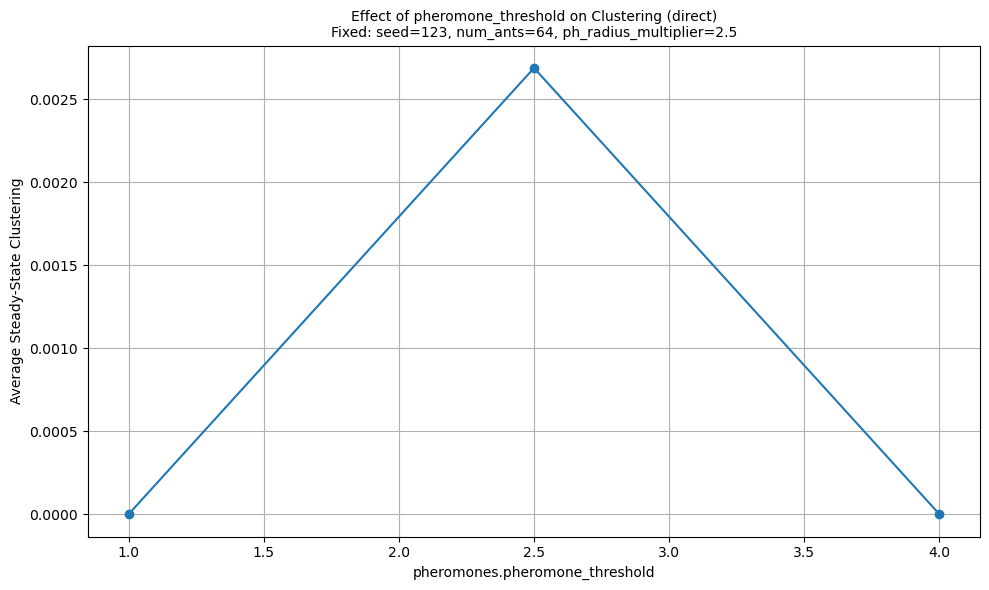

Available decay rates: [0.99 0.9  0.95]


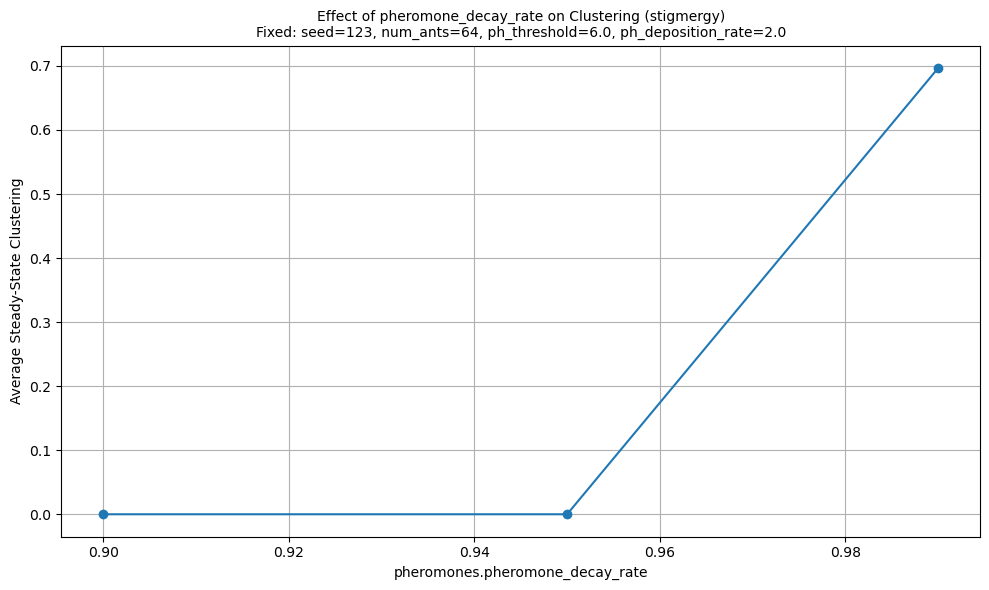

In [17]:
# Example: Compare effect of threshold in direct model
if LOAD_DIRECT and 'direct' in analysis_df['model_type'].values:
    thresholds = [1.0, 2.5, 4.0]  # Adjust based on your available data
    fig, ax = plot_parameter_comparison(
        param_name='pheromones.pheromone_threshold',
        param_values=thresholds,
        model_type='direct',
        fixed_params={
            'seed': 123,
            'num_ants': 64,
            'pheromones.pheromone_radius_multiplier': 2.5
        }
    )
    plt.show()

# Example: Compare effect of decay rate in stigmergy model
if LOAD_STIGMERGY and 'stigmergy' in analysis_df['model_type'].values:
    # First check which parameter values are available
    stigmergy_df = analysis_df[analysis_df['model_type'] == 'stigmergy']
    
    # Set filter params
    fixed_params = {
        'seed': 123,
        'num_ants': 64,
        'pheromones.pheromone_threshold': 6.0,
        'pheromones.pheromone_deposition_rate': 2.0
    }
    
    # Apply filters to check which decay rates are available
    filtered_df = stigmergy_df
    for key, value in fixed_params.items():
        filtered_df = filtered_df[filtered_df[key] == value]
    
    # Get available decay rates
    available_decay_rates = filtered_df['pheromones.pheromone_decay_rate'].unique()
    
    if len(available_decay_rates) > 0:
        print(f"Available decay rates: {available_decay_rates}")
        
        # Use available decay rates
        fig, ax = plot_parameter_comparison(
            param_name='pheromones.pheromone_decay_rate',
            param_values=available_decay_rates,
            model_type='stigmergy',
            fixed_params=fixed_params
        )
        plt.show()
    else:
        print("No matching stigmergy runs found with the specified parameters.")
        # Try with different parameters
        print("Attempting with different parameters...")
        
        # Get any available stigmergy runs with seed=123
        seed_runs = stigmergy_df[stigmergy_df['seed'] == 123]
        if len(seed_runs) > 0:
            # Find the first run and use its parameters
            first_run = seed_runs.iloc[10]
            try:
                decay_rates = [first_run['pheromones.pheromone_decay_rate']]
                threshold = first_run['pheromones.pheromone_threshold']
                deposition = first_run['pheromones.pheromone_deposition_rate']
                
                fig, ax = plot_parameter_comparison(
                    param_name='pheromones.pheromone_decay_rate',
                    param_values=decay_rates,
                    model_type='stigmergy',
                    fixed_params={
                        'seed': 123,
                        'num_ants': first_run['num_ants'],
                        'pheromones.pheromone_threshold': threshold,
                        'pheromones.pheromone_deposition_rate': deposition
                    }
                )
                plt.show()
            except Exception as e:
                print(f"Error plotting stigmergy data: {e}")

## Save Processed Data for Future Analysis

In [18]:
# Save the combined parameter and metrics DataFrame
analysis_df.to_csv('ant_simulation_analysis.csv', index=False)
print("Analysis data saved to 'ant_simulation_analysis.csv'")

# Optionally, save the run_id to data mapping for future use
import pickle

# Save data index mapping
with open('run_data_mapping.pkl', 'wb') as f:
    pickle.dump(run_id_to_data_index, f)

print("Run data mapping saved to 'run_data_mapping.pkl'")

Analysis data saved to 'ant_simulation_analysis.csv'
Run data mapping saved to 'run_data_mapping.pkl'
